# Part A: Ordinary Percolation

OpenPNM contains several percolation algorithms which are central to the multiphase models employed by pore networks. The essential idea is to identify pathways for fluid flow through the network using the entry capillary pressure as a threshold for passage between connected pores. The capillary pressure can either be associated to the pores themselves known as ``site percolation`` or the connecting throats known as ``bond percolation`` or a mixture of both. OpenPNM provides several models for calculating the entry pressure for a given pore or throat and it generally depends on the size of the pore or throat and the wettability to a particular phase characterised by the contact angle. If a pathway through the network connects pores into clusters that contain both an inlet and an outlet then it is deemed to be ``percolating``.

In this example we will demonstrate ``Ordinary Percolation`` which is the fastest and simplest algorithm to run. The number of steps involved in the algorithm is equal to the number of points that are specified in the run method. This can either be an integer, in which case the minimum and maximum capillary entry pressures in the network are used as limits and the integer value is used to create that number of intervals between the limits, or an array of specified pressured can be supplied.

The algorithm progresses incrementally from low pressure to high. At each step, clusters of connected pores are found with entry pressures below the current threshold and those that are not already invaded and connected to an inlet are set to be invaded at this pressure. Therefore the process is quasistatic and represents the steady state saturation that would be achieved if the inlet pressure were to be held at that threshold.

First do our imports

In [1]:
import openpnm as op
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(10)
from ipywidgets import interact, IntSlider
%matplotlib inline
ws = op.Workspace()
ws.settings["loglevel"] = 40

Create a 2D Cubic network with standard PSD and define the phase as Water and use Standard physics which implements the washburn capillary pressure relation for throat entry pressure.

In [2]:
N = 100
net = op.network.Cubic(shape=[N, N, 1], spacing=2.5e-5)
geom = op.geometry.StickAndBall(network=net, pores=net.Ps, throats=net.Ts)
water = op.phases.Water(network=net)
phys = op.physics.Standard(network=net, phase=water, geometry=geom)

We can check the model by looking at the model dict on the phys object

In [3]:
phys.models['throat.entry_pressure']

{'model': <function openpnm.models.physics.capillary_pressure.washburn(target, surface_tension='pore.surface_tension', contact_angle='pore.contact_angle', diameter='throat.diameter')>,
 'regen_mode': 'normal',
 'surface_tension': 'pore.surface_tension',
 'contact_angle': 'pore.contact_angle',
 'diameter': 'throat.diameter'}

Now set up and run the algorithm choosing the left and right sides of the network for inlets and outlets respectively. Because we did not set up the network with boundary pores with zero volume a little warning is given because the starting saturation for the algorithm is not zero. However, this is fine and because the network is quite large the starting saturation is actually quite close to zero.

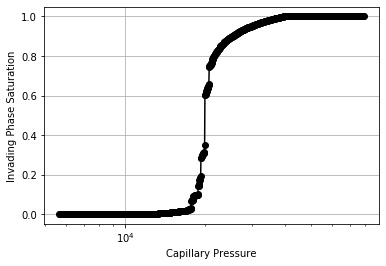

In [4]:
alg = op.algorithms.OrdinaryPercolation(network=net)
alg.setup(phase=water, pore_volume='pore.volume', throat_volume='throat.volume')
alg.set_inlets(pores=net.pores('left'))
alg.set_outlets(pores=net.pores('right'))
alg.run(points=1000)
alg.plot_intrusion_curve()
plt.show()

The algorithm completes very quickly and the invading phase saturation can be plotted versus the applied boundary pressure.

In [5]:
data = alg.get_intrusion_data()
mask = np.logical_and(np.asarray(data.Snwp) > 0.0 , np.asarray(data.Snwp) < 1.0)
mask = np.argwhere(mask).flatten()
pressures = np.asarray(data.Pcap)[mask]

As the network is 2D and cubic we can easily plot the invading phase configuration at the different invasion steps

In [6]:
def plot_saturation(step):
    arg = mask[step]
    Pc = np.ceil(data.Pcap[arg])
    sat = np.around(data.Snwp[arg], 3)
    is_perc = alg.is_percolating(Pc)
    pmask = alg['pore.invasion_pressure'] <= Pc
    im = pmask.reshape([N, N])
    fig, ax = plt.subplots(figsize=[5, 5])
    ax.imshow(im, cmap='Blues');
    title = ('Capillary Pressure: '+str(Pc)+' Saturation: '+str(sat)+
             ' Percolating : '+str(is_perc))
    plt.title(title)
    plt.show()

In [7]:
#NBVAL_IGNORE_OUTPUT
perc_thresh = alg.get_percolation_threshold()
thresh_step = np.argwhere(np.asarray(pressures) == perc_thresh)
interact(plot_saturation, step=IntSlider(min=0, max=len(mask)-1, step=1, value=thresh_step));

interactive(children=(IntSlider(value=186, description='step', max=444), Output()), _dom_classes=('widget-inte…